# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [2]:
# Import relevant packages 

import torch
from torch import nn, optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from PIL import Image
import json
import os

In [3]:
# Validate PyTorch installation
print("Torch Version:", torch.__version__)

# Validate torch.utils.data import
print("Torch DataLoader Imported:", 'DataLoader' in dir(torch.utils.data))

# Validate torchvision installation
print("Torchvision Version:", torchvision.__version__)

# Validate NumPy installation
print("NumPy Version:", np.__version__)

# Validate Matplotlib installation
print("Matplotlib Version:", matplotlib.__version__)

# Validate PIL installation
print("PIL Version:", Image.__version__)

# Validate JSON import
test_json = json.dumps({'test': 'success'})
print("JSON Test Passed:", test_json)

# Validate os import by checking the current working directory
print("Current Working Directory:", os.getcwd())

Torch Version: 2.4.0
Torch DataLoader Imported: True
Torchvision Version: 0.19.0
NumPy Version: 1.26.4
Matplotlib Version: 3.8.4
PIL Version: 10.4.0
JSON Test Passed: {"test": "success"}
Current Working Directory: /Users/shaylawilliams/aipnd-project


## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

## Define the Directories for the Datasets

In [6]:
# Define the Directories for the Datasets

data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

# Check if the directories exist
print("Train Directory Exists:", os.path.exists(train_dir))
print("Valid Directory Exists:", os.path.exists(valid_dir))
print("Test Directory Exists:", os.path.exists(test_dir))

Train Directory Exists: True
Valid Directory Exists: True
Test Directory Exists: True


In [7]:
# Define the transforms for the training, validation, and testing sets
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
print("Transforms defined for training, validation, and testing sets.")

# Load the datasets with ImageFolder
image_datasets = {
    'train': datasets.ImageFolder(train_dir, transform=data_transforms['train']),
    'valid': datasets.ImageFolder(valid_dir, transform=data_transforms['valid']),
    'test': datasets.ImageFolder(test_dir, transform=data_transforms['test']),
}
print(f"Datasets loaded: {len(image_datasets['train'])} training images, {len(image_datasets['valid'])} validation images, {len(image_datasets['test'])} test images.")

# Using the image datasets and the transforms, define the dataloaders
dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=64, shuffle=True),
    'valid': DataLoader(image_datasets['valid'], batch_size=64),
    'test': DataLoader(image_datasets['test'], batch_size=64),
}
print("Dataloaders created for training, validation, and testing sets.")

Transforms defined for training, validation, and testing sets.
Datasets loaded: 6552 training images, 818 validation images, 820 test images.
Dataloaders created for training, validation, and testing sets.


### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [9]:
# Load the JSON file that maps category labels to flower names
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

# Print the first few mappings to verify
print("Category to Name Mapping:", list(cat_to_name.items())[:5])

Category to Name Mapping: [('21', 'fire lily'), ('3', 'canterbury bells'), ('45', 'bolero deep blue'), ('1', 'pink primrose'), ('34', 'mexican aster')]


# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

One last important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to
GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module.

**Note for Workspace users:** If your network is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. Typically this happens with wide dense layers after the convolutional layers. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and train again.

## Build and train the network

In [12]:
def load_model(weights='VGG16_Weights.IMAGENET1K_V1'):
    """Load a pre-trained VGG16 model and replace the classifier with a custom classifier."""
    
    # Load the VGG16 model pre-trained on ImageNet data
    model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
    print("Pre-trained VGG16 model loaded successfully with updated weights.")
    
    # Freeze the parameters of the pre-trained model so they are not updated during training
    for param in model.parameters():
        param.requires_grad = False

    # Define a new classifier to replace the VGG16's original classifier
    classifier = nn.Sequential(
        nn.Linear(25088, 4096),  # Input layer: 25088 features from VGG16, output: 4096 units
        nn.ReLU(),  # Activation function
        nn.Dropout(p=0.5),  # Dropout to prevent overfitting
        nn.Linear(4096, 1024),  # Hidden layer: 4096 input units, 1024 output units
        nn.ReLU(),  # Activation function
        nn.Dropout(p=0.5),  # Dropout to prevent overfitting
        nn.Linear(1024, 102),   # Output layer: 102 classes for the flower dataset
        nn.LogSoftmax(dim=1)    # LogSoftmax for output probabilities
    )

    # Replace the original classifier in the VGG16 model with the new classifier
    model.classifier = classifier
    print("New feed-forward classifier defined and attached to the pre-trained VGG16 model.")
    
    return model

def train_model(model, dataloaders, criterion, optimizer, device, num_epochs=10):
    """Train the model, validate on the validation set, and track performance."""
    
    best_accuracy = 0.0  # Initialize the best validation accuracy
    steps = 0  # Track the number of batches processed

    train_losses = []  # List to store training loss per epoch
    validation_losses = []  # List to store validation loss per epoch
    validation_accuracies = []  # List to store validation accuracy per epoch

    # Loop over the number of epochs
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0  # Initialize running loss for the epoch
        validation_loss = 0.0  # Initialize validation loss
        accuracy = 0.0  # Initialize accuracy

        # Loop over the training data
        for inputs, labels in dataloaders['train']:
            steps += 1  # Increment the steps counter
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to the CPU

            optimizer.zero_grad()  # Reset gradients from the previous iteration

            # Forward pass: compute predicted outputs by passing inputs to the model
            logps = model(inputs)
            # Calculate the loss
            loss = criterion(logps, labels)
            # Backward pass: compute the gradient of the loss with respect to model parameters
            loss.backward()
            # Perform a single optimization step (parameter update)
            optimizer.step()

            running_loss += loss.item()  # Update running loss

        # Validation after training completes for the epoch
        model.eval()  # Set the model to evaluation mode

        with torch.no_grad():  # Disable gradient calculation
            for inputs, labels in dataloaders['valid']:
                inputs, labels = inputs.to(device), labels.to(device)
                # Forward pass
                logps = model(inputs)
                # Calculate validation loss
                batch_loss = criterion(logps, labels)
                validation_loss += batch_loss.item()

                # Calculate validation accuracy
                ps = torch.exp(logps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

        # Calculate the average validation accuracy
        validation_accuracy = accuracy / len(dataloaders['valid'])

        # Save the losses and accuracy for plotting
        train_losses.append(running_loss/len(dataloaders['train']))
        validation_losses.append(validation_loss/len(dataloaders['valid']))
        validation_accuracies.append(validation_accuracy)

        # Print a summary at the end of the epoch
        print(f"Epoch {epoch+1}/{num_epochs} complete.. "
              f"Train loss: {running_loss/len(dataloaders['train']):.3f}.. "
              f"Validation loss: {validation_loss/len(dataloaders['valid']):.3f}.. "
              f"Validation accuracy: {validation_accuracy:.3f}")

        # Track the best validation accuracy and save the model if it improves
        if validation_accuracy > best_accuracy:
            best_accuracy = validation_accuracy

    print("Training complete.")  # Indicate that training is finished
    
    # Return the model and the collected metrics for plotting
    return model, train_losses, validation_losses, validation_accuracies

In [13]:
# Set the device to CPU, since we're using your local environment without GPU
device = torch.device("cpu")
print(f"Device set to: {device}")

# Load the pre-trained VGG16 model with the custom classifier
model = load_model()

# Move the model to the device (CPU)
model.to(device)
print("Model loaded and moved to CPU.")

# Define the loss function (Negative Log-Likelihood Loss for multi-class classification)
criterion = nn.NLLLoss()
print("Loss function defined.")

# Define the optimizer (Adam optimizer for the classifier's parameters with learning rate 0.001)
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)
print("Optimizer defined.")

# Validate DataLoader existence
if 'train' in dataloaders and 'valid' in dataloaders:
    print("DataLoaders for 'train' and 'valid' found.")
else:
    print("Error: DataLoaders not found or incorrectly defined.")

# Train the model for 10 epochs
print("Starting training for 10 epochs...")
trained_model = train_model(model, dataloaders, criterion, optimizer, device, num_epochs=10)
print("Training complete.")

Device set to: cpu
Pre-trained VGG16 model loaded successfully with updated weights.
New feed-forward classifier defined and attached to the pre-trained VGG16 model.
Model loaded and moved to CPU.
Loss function defined.
Optimizer defined.
DataLoaders for 'train' and 'valid' found.
Starting training for 10 epochs...
Epoch 1/10 complete.. Train loss: 3.361.. Validation loss: 1.492.. Validation accuracy: 0.605
Epoch 2/10 complete.. Train loss: 1.944.. Validation loss: 0.883.. Validation accuracy: 0.755
Epoch 3/10 complete.. Train loss: 1.638.. Validation loss: 0.754.. Validation accuracy: 0.802
Epoch 4/10 complete.. Train loss: 1.542.. Validation loss: 0.675.. Validation accuracy: 0.823
Epoch 5/10 complete.. Train loss: 1.432.. Validation loss: 0.623.. Validation accuracy: 0.840
Epoch 6/10 complete.. Train loss: 1.392.. Validation loss: 0.540.. Validation accuracy: 0.855
Epoch 7/10 complete.. Train loss: 1.296.. Validation loss: 0.544.. Validation accuracy: 0.848
Epoch 8/10 complete.. Tra

## Plotting the Training and Validation Loss & Accuracy

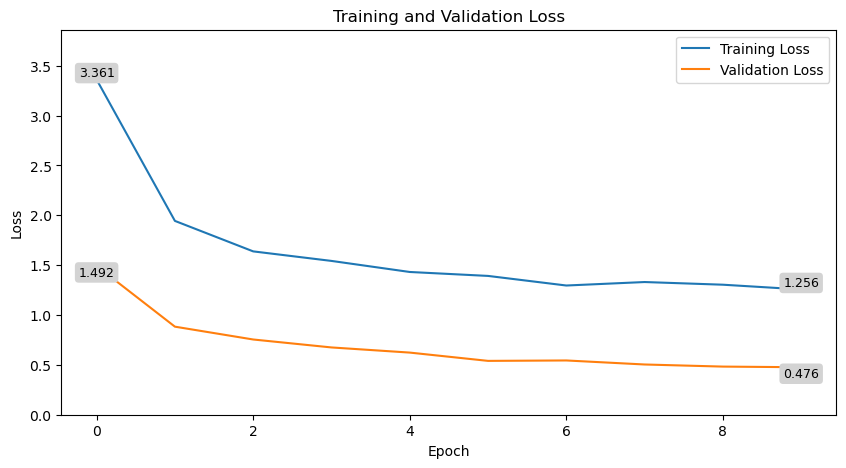

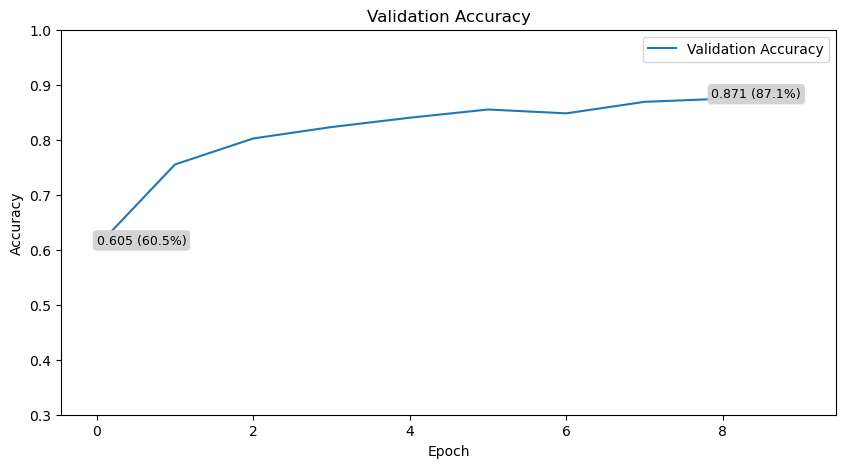

In [26]:
import matplotlib.pyplot as plt

# Unpack the results from training for plotting
trained_model, train_losses, validation_losses, validation_accuracies = trained_model

# Plotting the training and validation loss over epochs
plt.figure(figsize=(10,5))  # Set the figure size for better visibility
plt.plot(train_losses, label='Training Loss')  # Plot the training loss
plt.plot(validation_losses, label='Validation Loss')  # Plot the validation loss
plt.title('Training and Validation Loss')  # Set the title of the plot
plt.xlabel('Epoch')  # Label the x-axis as 'Epoch'
plt.ylabel('Loss')  # Label the y-axis as 'Loss'
plt.ylim(0.0, max(max(train_losses), max(validation_losses)) + 0.5)  # Set y-axis limits dynamically based on max values
plt.legend()  # Add a legend to differentiate between training and validation loss

# Adding data labels for the first and last points of Training Loss with background color
plt.text(0, train_losses[0], f'{train_losses[0]:.3f}', ha='center', va='bottom', fontsize=9, color='black',
         bbox=dict(facecolor='lightgrey', edgecolor='none', boxstyle='round,pad=0.3'))
plt.text(len(train_losses)-1, train_losses[-1], f'{train_losses[-1]:.3f}', ha='center', va='bottom', fontsize=9, color='black',
         bbox=dict(facecolor='lightgrey', edgecolor='none', boxstyle='round,pad=0.3'))

# Adding data labels for the first and last points of Validation Loss with background color
plt.text(0, validation_losses[0], f'{validation_losses[0]:.3f}', ha='center', va='top', fontsize=9, color='black',
         bbox=dict(facecolor='lightgrey', edgecolor='none', boxstyle='round,pad=0.3'))
plt.text(len(validation_losses)-1, validation_losses[-1], f'{validation_losses[-1]:.3f}', ha='center', va='top', fontsize=9, color='black',
         bbox=dict(facecolor='lightgrey', edgecolor='none', boxstyle='round,pad=0.3'))

plt.show()  # Display the plot

# Plotting the validation accuracy over epochs
plt.figure(figsize=(10,5))  # Set the figure size for better visibility
plt.plot(validation_accuracies, label='Validation Accuracy')  # Plot the validation accuracy
plt.title('Validation Accuracy')  # Set the title of the plot
plt.xlabel('Epoch')  # Label the x-axis as 'Epoch'
plt.ylabel('Accuracy')  # Label the y-axis as 'Accuracy'
plt.ylim(0.3, 1.0)  # Set y-axis limits
plt.yticks([0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])  # Define custom y-ticks
plt.legend()  # Add a legend to identify the plot line

# Adding data labels for the first and last points of Validation Accuracy with background color
plt.text(0, validation_accuracies[0], f'{validation_accuracies[0]:.3f} ({validation_accuracies[0]*100:.1f}%)', 
         ha='left', va='bottom', fontsize=9, color='black',
         bbox=dict(facecolor='lightgrey', edgecolor='none', boxstyle='round,pad=0.3'))
plt.text(len(validation_accuracies)-1, validation_accuracies[-1], f'{validation_accuracies[-1]:.3f} ({validation_accuracies[-1]*100:.1f}%)', 
         ha='right', va='bottom', fontsize=9, color='black',
         bbox=dict(facecolor='lightgrey', edgecolor='none', boxstyle='round,pad=0.3'))

plt.show()  # Display the plot

#### Summary of Training Results:

My model showed significant improvement over time, starting with a high training loss and validation loss. By the end of 10 epochs, both the training and validation losses had significantly decreased, indicating that the model became much more accurate. The validation accuracy also improved greatly, showing that the model became increasingly effective in correctly classifying images.

## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [48]:
def test_model(model, dataloader, criterion, device):
    """Test the trained model on the test dataset and return the test accuracy and loss."""
    
    model.eval()  # Set the model to evaluation mode
    test_loss = 0.0  # Initialize test loss
    accuracy = 0.0  # Initialize accuracy

    print("Starting testing...")  # Indicate the start of the testing process
    
    with torch.no_grad():  # Disable gradient calculation
        for inputs, labels in dataloader['test']:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            logps = model(inputs)
            
            # Calculate test loss
            batch_loss = criterion(logps, labels)
            test_loss += batch_loss.item()
            
            # Calculate accuracy
            ps = torch.exp(logps)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

            # Print the batch results
            print(f"Processed batch - Batch Loss: {batch_loss.item():.3f}, "
                  f"Current Accuracy: {torch.mean(equals.type(torch.FloatTensor)).item():.3f}")
    
    # Calculate the average test accuracy
    test_accuracy = accuracy / len(dataloader['test'])
    
    # Print the final test results
    print(f"Test complete. "
          f"Test Loss: {test_loss/len(dataloader['test']):.3f}.. "
          f"Test Accuracy: {test_accuracy:.3f}")
    
    return test_loss, test_accuracy

# Running the test function
test_loss, test_accuracy = test_model(trained_model, dataloaders, criterion, device)

Starting testing...
Processed batch - Batch Loss: 0.605, Current Accuracy: 0.844
Processed batch - Batch Loss: 0.475, Current Accuracy: 0.844
Processed batch - Batch Loss: 0.535, Current Accuracy: 0.812
Processed batch - Batch Loss: 0.985, Current Accuracy: 0.703
Processed batch - Batch Loss: 0.265, Current Accuracy: 0.938
Processed batch - Batch Loss: 0.684, Current Accuracy: 0.812
Processed batch - Batch Loss: 0.221, Current Accuracy: 0.969
Processed batch - Batch Loss: 0.600, Current Accuracy: 0.812
Processed batch - Batch Loss: 0.189, Current Accuracy: 0.953
Processed batch - Batch Loss: 0.146, Current Accuracy: 0.938
Processed batch - Batch Loss: 1.106, Current Accuracy: 0.750
Processed batch - Batch Loss: 0.666, Current Accuracy: 0.812
Processed batch - Batch Loss: 0.765, Current Accuracy: 0.808
Test complete. Test Loss: 0.557.. Test Accuracy: 0.846


#### Summary of Testing Results: 

When tested on completely unseen data, the model showed strong performance, achieving a high test accuracy. This confirms that the model has generalized well and can effectively classify new images, with consistent results between the validation and test performances.

## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

# Save the checkpoint 

In [50]:
# Attach the class-to-index mapping to the model
model.class_to_idx = image_datasets['train'].class_to_idx

# Create the checkpoint dictionary
checkpoint = {
    'state_dict': model.state_dict(),  # Save the model's state dict
    'optimizer_state_dict': optimizer.state_dict(),  # Save the optimizer's state dict
    'class_to_idx': model.class_to_idx,  # Save the class-to-index mapping
    'epochs': 10,  # Save the number of training epochs
    'classifier': model.classifier,  # Save the classifier architecture
}

# Save the checkpoint
torch.save(checkpoint, 'model_checkpoint.pth')
print("Model checkpoint saved successfully.")

Model checkpoint saved successfully.


## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

### Write a function that loads a checkpoint and rebuilds the model

In [52]:
def load_checkpoint(filepath):
    """Load a model checkpoint and rebuild the model."""
    
    # Load the checkpoint from file
    checkpoint = torch.load(filepath)
    print("Checkpoint loaded successfully from:", filepath)
    
    # Load the pre-trained VGG16 model
    model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
    print("Pre-trained VGG16 model loaded.")
    
    # Freeze the parameters of the pre-trained model
    for param in model.parameters():
        param.requires_grad = False
    print("Pre-trained model parameters frozen.")
    
    # Rebuild the custom classifier
    model.classifier = checkpoint['classifier']
    print("Custom classifier reattached to the model.")
    
    # Load the state dict into the model
    model.load_state_dict(checkpoint['state_dict'])
    print("Model state dict loaded.")
    
    # Load the class-to-index mapping
    model.class_to_idx = checkpoint['class_to_idx']
    print("Class-to-index mapping loaded.")
    
    # Rebuild the optimizer
    optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.001)
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    print("Optimizer state dict loaded.")
    
    # Load the number of epochs trained
    epochs = checkpoint['epochs']
    print(f"Model trained for {epochs} epochs loaded.")

    print("Model checkpoint loaded and ready to use.")
    
    return model, optimizer, epochs

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [141]:
def process_image(image_path):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns a Numpy array
    '''
    # Open the image file
    pil_image = Image.open(image_path)
    
    # Resize the image, keeping the aspect ratio
    # Ensure the shortest side is 256 pixels
    if pil_image.size[0] < pil_image.size[1]:
        pil_image = pil_image.resize((256, int(256 * pil_image.size[1] / pil_image.size[0])))
    else:
        pil_image = pil_image.resize((int(256 * pil_image.size[0] / pil_image.size[1]), 256))
    
    # Get the dimensions for the center crop
    width, height = pil_image.size
    new_width, new_height = 224, 224
    left = (width - new_width) / 2
    top = (height - new_height) / 2
    right = left + new_width
    bottom = top + new_height

    # Crop the image
    pil_image = pil_image.crop((left, top, right, bottom))
    
    # Convert image to Numpy array and scale pixel values
    np_image = np.array(pil_image) / 255.0
    
    # Normalize the image with mean and standard deviation
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    np_image = (np_image - mean) / std

    # Reorder dimensions to color channel first
    np_image = np_image.transpose((2, 0, 1))

    return np_image

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [179]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    # ax.axis('off')  # Hide axis numbers and ticks
    
    return ax

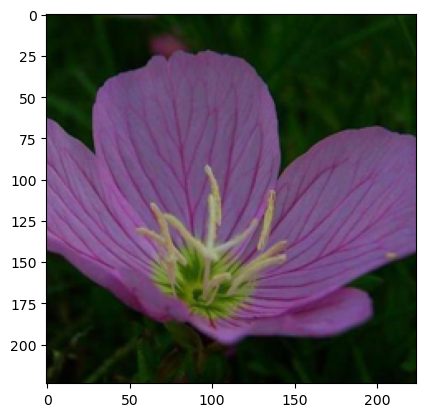

In [181]:
# Path to the first test image
image_path = 'flowers/test/1/image_06752.jpg'  # Example image path

# Process the image using your function
processed_image = process_image(image_path)

# Convert the processed image to a PyTorch tensor
tensor_image = torch.from_numpy(processed_image)

# Use imshow to display the processed image
imshow(tensor_image)
plt.show()

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [183]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    
    Args:
    image_path (str): Path to the image
    model (torchvision.models): Trained model
    topk (int): Number of top predictions to return
    
    Returns:
    probs (list): Top K probabilities
    classes (list): Corresponding classes for the top K probabilities
    '''
    # Process the image
    image = process_image(image_path)
    
    # Convert to PyTorch tensor
    image = torch.from_numpy(image).type(torch.FloatTensor)
    
    # Add batch dimension to the tensor
    image = image.unsqueeze(0)

    # Move model to evaluation mode and to the same device as the image
    model.eval()
    model.to(image.device)

    # Perform inference
    with torch.no_grad():
        output = model.forward(image)
    
    # Calculate the probabilities
    ps = torch.exp(output)
    
    # Get the top K probabilities and corresponding classes
    top_p, top_class = ps.topk(topk, dim=1)
    
    # Convert probabilities and classes to lists
    top_p = top_p.cpu().numpy().squeeze().tolist()
    top_class = top_class.cpu().numpy().squeeze().tolist()

    # Invert class_to_idx to map indices to classes
    idx_to_class = {v: k for k, v in model.class_to_idx.items()}
    classes = [idx_to_class[c] for c in top_class]
    
    return top_p, classes

## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

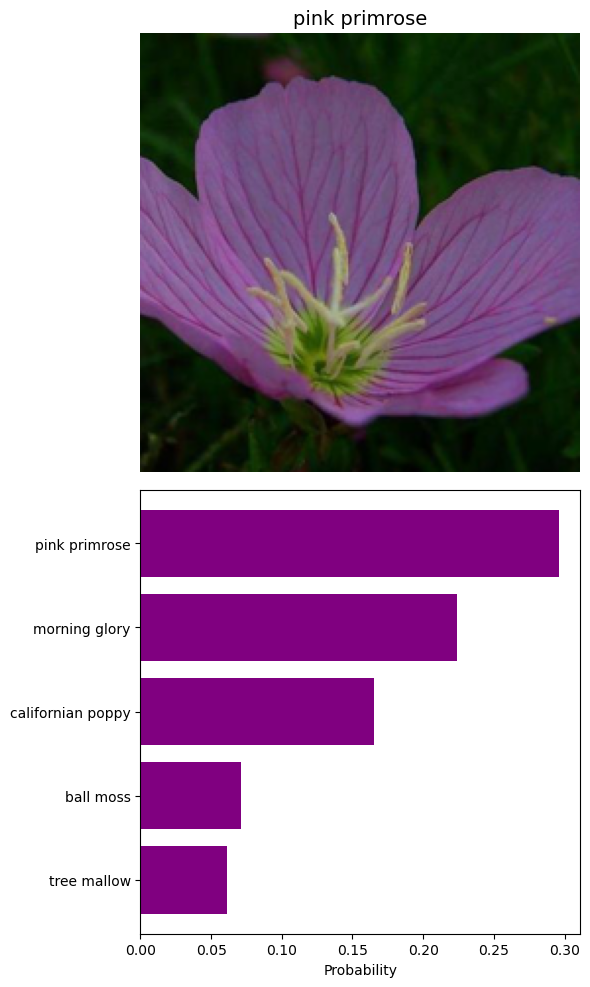

In [211]:
# Display an image along with the top 5 classes
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

def display_image_and_predictions(image_path, model):
    # Process the image and get the predictions
    processed_image = process_image(image_path)
    probs, classes = predict(image_path, model)
    
    # Convert classes from integers to actual flower names
    flower_names = [cat_to_name[str(cls)] for cls in classes]

    # Sort the probabilities and corresponding class names in descending order
    sorted_probs, sorted_flower_names = zip(*sorted(zip(probs, flower_names), reverse=True))
    
    # Plot the image and title
    plt.figure(figsize=(6, 10))
    ax = plt.subplot(2, 1, 1)
    
    # Convert processed image to tensor and display
    imshow(torch.from_numpy(processed_image), ax=ax) 
    ax.set_title(sorted_flower_names[0], fontsize=14)  # Set title above the image
    ax.axis('off')  # Hide axis numbers and ticks
    
    # Plot the probabilities as a bar chart
    ax2 = plt.subplot(2, 1, 2)
    y_pos = range(len(sorted_flower_names))
    ax2.barh(y_pos, sorted_probs, color='purple')  # Sorted from largest to smallest
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels(sorted_flower_names)
    ax2.set_xlabel('Probability')
    ax2.invert_yaxis()  # Invert y-axis to show largest probability on top

    plt.tight_layout()
    plt.show()

# Path to the first test image
image_path = 'flowers/test/1/image_06752.jpg'
display_image_and_predictions(image_path, trained_model)

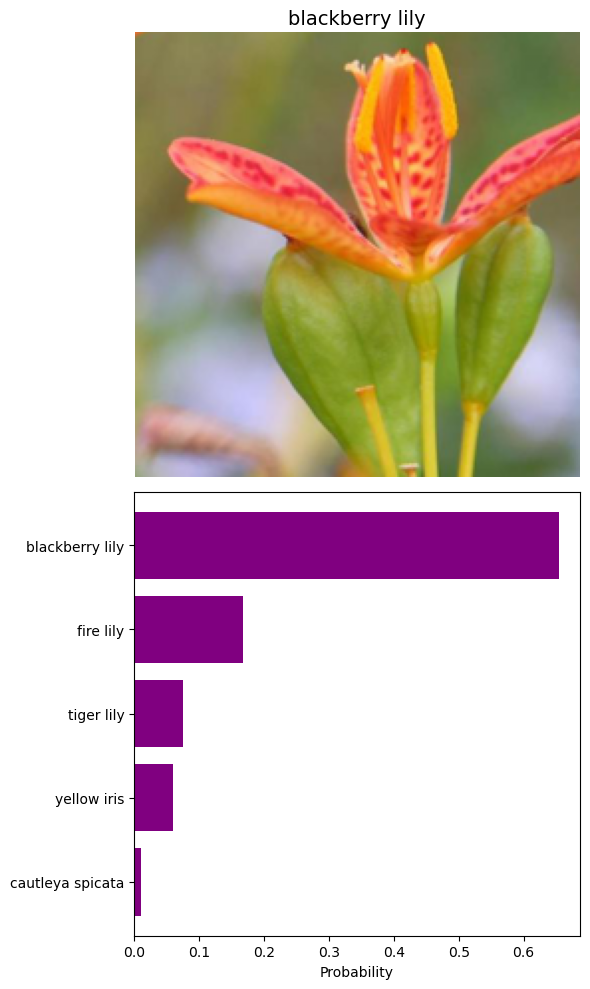

In [231]:
# Path to a second image; This image shows only one prediction and after Googling it, it's correct!
new_image_path = 'flowers/test/102/image_08030.jpg'

# Display the image and its top 5 predicted classes (if any)
display_image_and_predictions(new_image_path, trained_model)